Unzipping Dataset

In [ ]:
import pickle
import numpy as np
import pandas as pd
import os

directory = '../../affect-recognition/data/WESAD.zip'
output_directory = '../../affect-recognition/data/'

os.listdir(output_directory)

import zipfile
with zipfile.ZipFile(directory, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

Plotting Individual Data

In [12]:
import pickle
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from ecgdetectors import Detectors
from scipy import signal
import pickle
from peak_valley import compute_peak_valley
filelists = ['../../affect-recognition/data/WESAD/'+a+'/'+a+'.pkl' for a in os.listdir('../../affect-recognition/data/WESAD/') if a[-1] not in ['s','f']]

<IPython.core.display.Javascript object>


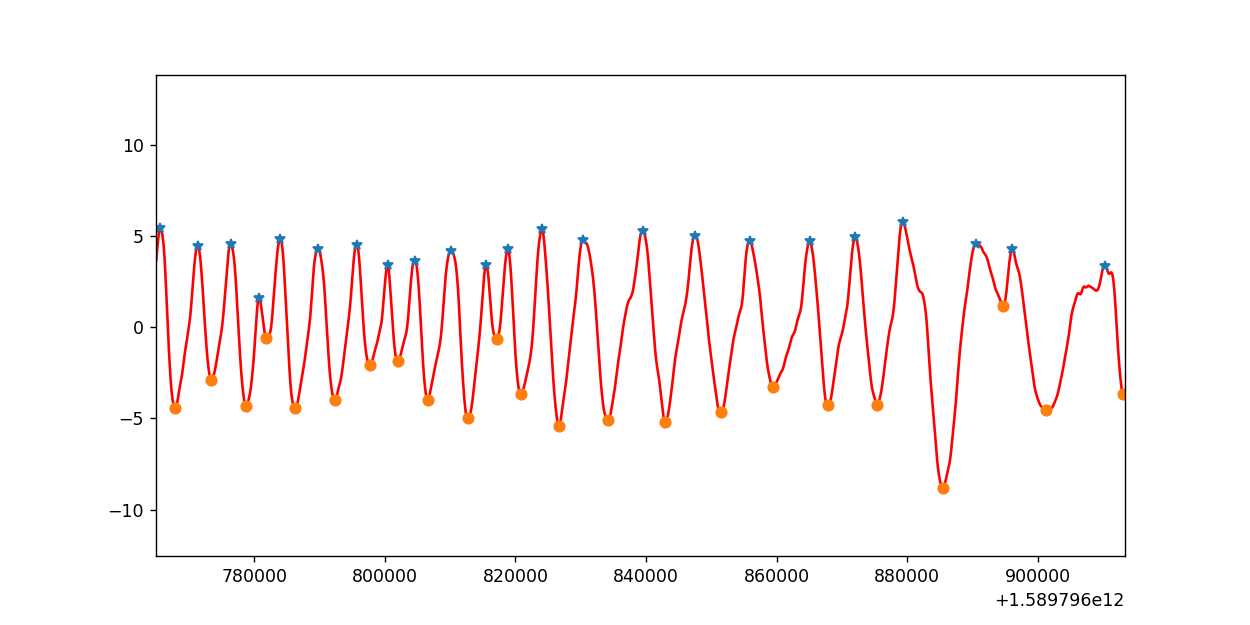

'../../affect-recognition/data/WESAD/S13/S13.pkl'

In [14]:
%matplotlib notebook
def get_ecg_rr(ecg_data):
    detectors = Detectors(700)
    rpeaks = detectors.hamilton_detector(ecg_data[:,1])
    ecg_r_ts = ecg_data[np.array(rpeaks),0]
    ecg_rr_ts = ecg_r_ts[1:]
    ecg_rr_sample = np.diff(ecg_r_ts)
    ecg_rr = pd.DataFrame(np.vstack([ecg_rr_ts,ecg_rr_sample]).T,columns=['time','rr'])
    ecg_rr['timestamp'] = ecg_rr['time'].apply(lambda a:datetime.utcfromtimestamp(a))
    return ecg_rr

def bandpass_filter(data,Fs=64,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.3,0.5,3.5,4,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def bandpass_filter_respiration(data,Fs=700,fil_type='ppg'):
    X0 = data[:,1]
    X1 = signal.detrend(X0,axis=0,type='constant')
    X2 = np.zeros((np.shape(X1)[0],data.shape[1]))
    nyq = Fs/2
    b = signal.firls(219,np.array([0,0.03,0.1,2,2.5,nyq]),
                              np.array([0,0,1,1,0,0]),np.array([10,1,1]),fs=nyq*2)
    a = [1]
    X2[:,0] = data[:,0]
    X2[:,1] = signal.filtfilt(b, a, X1)
    return X2

def save_participant_data(filename,ecg_fs = 700,ppg_fs = 64,window_size=8):
    data = pickle.load(open(filename,'rb'),encoding='latin1')
    ppg_data = data['signal']['wrist']['BVP']
    ecg_data = data['signal']['chest']['ECG']
    respiration_data = data['signal']['chest']['Resp']
    total_seconds = ppg_data.shape[0]/ppg_fs
    start_ts = datetime.utcnow().timestamp()
    ecg_ts = start_ts + np.arange(0,total_seconds,1/ecg_fs)
    respiration_ts = ecg_ts
    respiration_data = np.vstack([respiration_ts,respiration_data.reshape(-1)]).T
    ecg_data = np.vstack([ecg_ts,ecg_data.reshape(-1)]).T
    ecg_rr1 = get_ecg_rr(ecg_data)
    ecg_rr = ecg_rr1.values
    ppg_ts = start_ts + np.arange(0,total_seconds,1/ppg_fs)
    ppg_data = np.vstack([ppg_ts,ppg_data.reshape(-1)]).T
    ppg_data = bandpass_filter(ppg_data,Fs=ppg_fs,fil_type='ppg')
    respiration_data = bandpass_filter_respiration(respiration_data,Fs=ecg_fs,fil_type='ppg')
    respiration_data[:,0] = respiration_data[:,0]*1000
    peak_index,valley_index = compute_peak_valley(respiration_data)
    plt.figure(figsize=(10,5))
    plt.plot(respiration_data[:,0],respiration_data[:,1],'r')
    plt.plot(respiration_data[peak_index,0],respiration_data[peak_index,1],'*')
    plt.plot(respiration_data[valley_index,0],respiration_data[valley_index,1],'o')
    plt.show()
#     ppg_data = pd.DataFrame(ppg_data,columns=['time','ppg']).dropna()
#     ppg_data['timestamp'] = ppg_data['time'].apply(lambda a:datetime.utcfromtimestamp(a))
    
#     ppg_windows = pd.DataFrame([[a['time'].min(),a['time'].max(),a[['time','ppg']]] 
#                                 for i,a in ppg_data.groupby(pd.Grouper(key='timestamp',freq=str(window_size)+'S')) if a.shape[0]==window_size*ppg_fs],columns=['start_time',
#                                                                                                                                'end_time',
#                                                                                                                                'data'])
#     ppg_windows['ecg_rr'] = ppg_windows.apply(lambda a:np.mean(ecg_rr[np.where((ecg_rr[:,0]>=a['start_time'])&(ecg_rr[:,0]<a['end_time']))[0],1]),axis=1)
#     print(ppg_windows.shape)
#     if not os.path.isdir(output_directory+str(window_size)):
#         os.makedirs(output_directory+str(window_size))
#     final_path = output_directory+str(window_size)+'/'
#     participant_name = filename.split('/')[-1]
#     pickle.dump(ppg_windows,open(final_path+participant_name,'wb'))
    
output_directory = '../../affect-recognition/data/'
final = [save_participant_data(f,window_size=6) for f in filelists[:1]]
# for filename in filelists:
filelists[0]
    
#     print(ecg_rr.head(),ppg_data.head())

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(data['signal']['wrist']['BVP'][255000:260000])
# plt.plot(data['signal']['chest']['ECG'][:30000])
data['signal']['wrist']['BVP'].shape[0]/64,data['signal']['chest']['ECG'].shape[0]/700

In [ ]:
data['label'].shape